<a href="https://colab.research.google.com/github/Series-Parallel/Machine_in_Deep_Learning/blob/main/Neural_Networks_with_ArgMax_and_SoftMax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

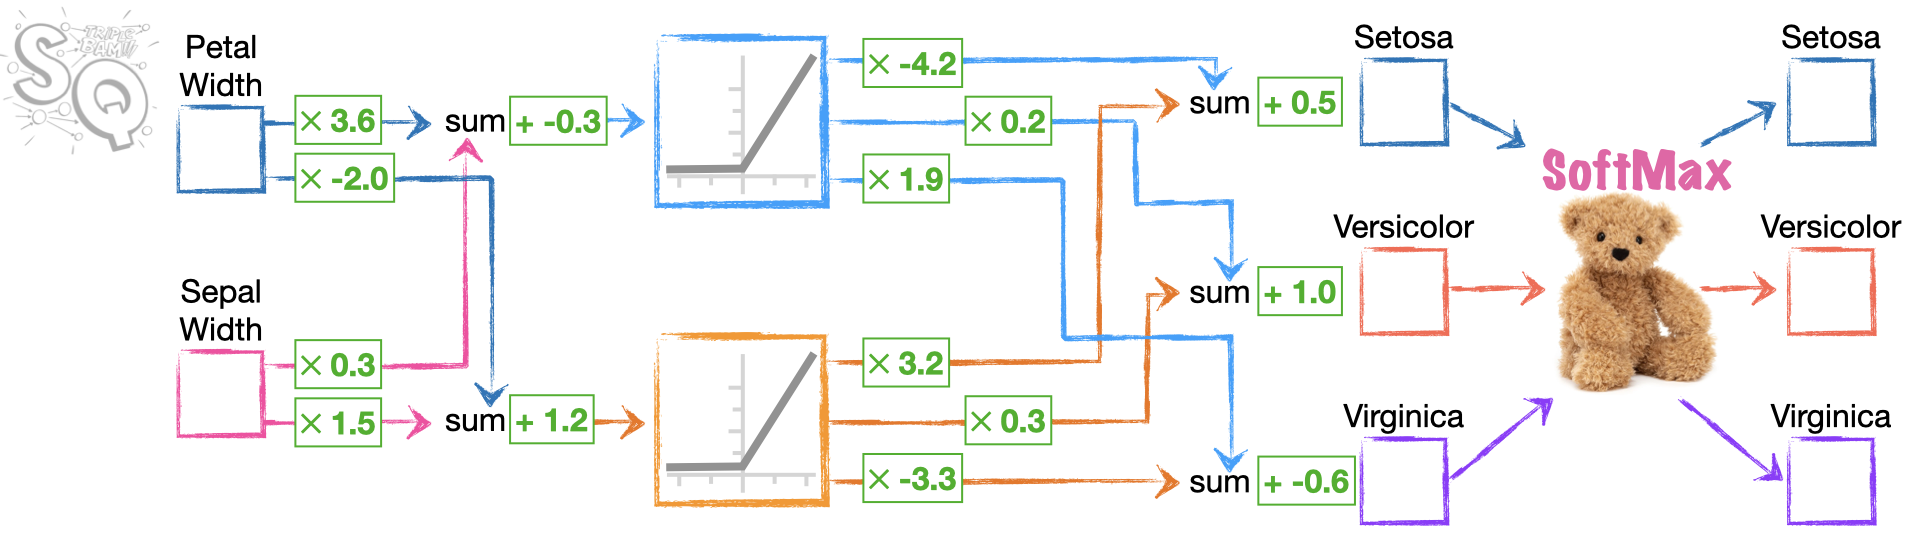

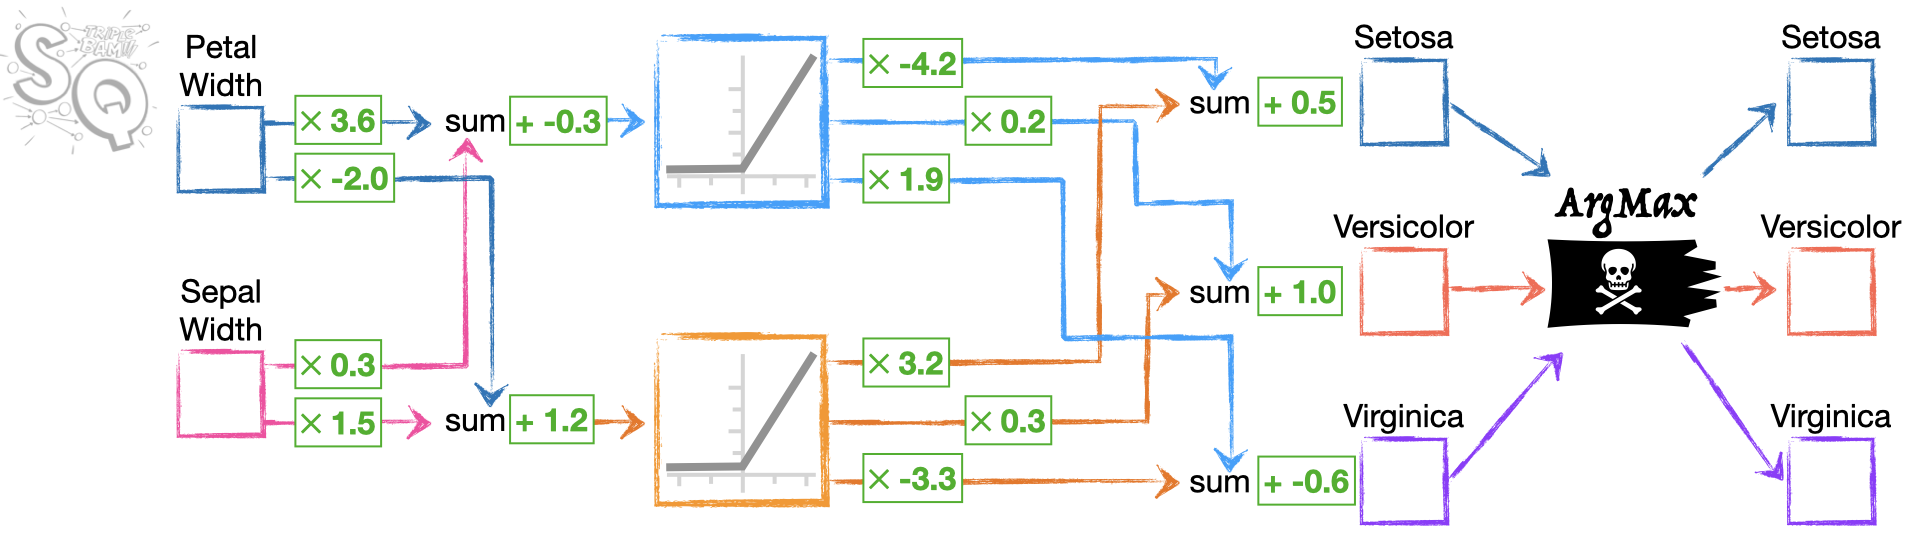

In [ ]:
!pip install lightning > /dev/null

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import lightning as L
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
url = "https://raw.githubusercontent.com/StatQuest/signa/main/chapter_04/iris.txt"
df = pd.read_table(url, sep=",", header=None)

In [ ]:
df.head()

In [ ]:
df.columns = ["sepal_length",
              "sepal_width",
              "petal_length",
              "petal_width",
              "class"]
df.head()

In [ ]:
df.shape

In [ ]:
df['class'].nunique()

In [ ]:
df['class'].unique()

In [ ]:
for class_name in df['class'].unique(): # for each unique class name...

    ## ...print out the number of rows associated with it
    print(class_name, ": ", sum(df['class'] == class_name), sep="")

In [ ]:
df[['petal_width', 'sepal_width']].head()

In [ ]:
input_values = df[['petal_width', 'sepal_width']]
input_values.head()

In [ ]:
label_values = df['class']
label_values.head()

In [ ]:
classes_as_numbers = label_values.factorize()[0]

In [ ]:
classes_as_numbers

In [ ]:
input_train, input_test, label_train, label_test = train_test_split(input_values,
                                                                    classes_as_numbers,
                                                                    test_size=0.25,
                                                                    stratify=classes_as_numbers)

In [ ]:
input_train.shape

In [ ]:
label_train.shape

In [ ]:
input_test.shape

In [ ]:
label_test.shape

In [ ]:
one_hot_label_train = F.one_hot(torch.tensor(label_train)).type(torch.float32)

In [ ]:
one_hot_label_train[:10]

In [ ]:
max_vals_in_input_train = input_train.max()

In [ ]:
max_vals_in_input_train

In [ ]:
min_vals_in_input_train = input_train.min()

In [ ]:
min_vals_in_input_train

In [ ]:
input_train = (input_train - min_vals_in_input_train) / (max_vals_in_input_train - min_vals_in_input_train)
input_train.head()

In [ ]:
input_test = (input_test - min_vals_in_input_train) / (max_vals_in_input_train - min_vals_in_input_train)
input_test.head()

In [ ]:
input_train_tensors = torch.tensor(input_train.values).type(torch.float32)

In [ ]:
input_train_tensors[:5]

In [ ]:
input_test_tensors = torch.tensor(input_test.values).type(torch.float32)

In [ ]:
input_test_tensors[:5]

In [ ]:
train_dataset = TensorDataset(input_train_tensors, one_hot_label_train)
train_dataloader = DataLoader(train_dataset)

# Building a neural network with multiple inputs and outputs with PyTorch and Lightning

In [ ]:
class MultipleInsOuts(L.LightningModule):

  def __init__(self):

    super().__init__()

    L.seed_everything(seed=42)

    self.input_to_hidden = nn.Linear(in_features=2, out_features=2, bias=True)
    self.hidden_to_output = nn.Linear(in_features=2, out_features=3, bias=True)
    self.loss = nn.CrossEntropyLoss()

  def forward(self,input):
    hidden = self.input_to_hidden(input)
    output_values = self.hidden_to_output(torch.relu(hidden))
    return(output_values)

  def configure_optimizers(self):
    return Adam(self.parameters(), lr=0.001)

  def training_step(self, batch, batch_idx):
    inputs, labels = batch
    outputs = self.forward(inputs)
    loss = self.loss(outputs, labels)
    return loss

# Training our Neural Network

In [ ]:
model = MultipleInsOuts()

In [ ]:
trainer = L.Trainer(max_epochs=10)
trainer.fit(model, train_dataloaders=train_dataloader)

In [ ]:
predictions = model(input_test_tensors)

In [ ]:
predictions[0:4,]

In [ ]:
predicted_labels = torch.argmax(predictions, dim=1) ## dim=0 applies argmax to rows, dim=1 applies argmax to columns
predicted_labels[0:4]

In [ ]:
torch.sum(torch.eq(torch.tensor(label_test), predicted_labels)) / len(predicted_labels)

In [ ]:
path_to_checkpoint = trainer.checkpoint_callback.best_model_path

In [ ]:
trainer = L.Trainer(max_epochs=100) # Before, max_epochs=10, so, by setting it to 100, we're adding 90 more.

trainer.fit(model, train_dataloaders=train_dataloader, ckpt_path=path_to_checkpoint)

In [ ]:
predictions = model(input_test_tensors)

In [ ]:
predicted_labels = torch.argmax(predictions, dim=1)

In [ ]:
torch.sum(torch.eq(torch.tensor(label_test), predicted_labels)) / len(predicted_labels)

In [ ]:
for name, param in model.named_parameters():
    print(name, torch.round(param.data, decimals=2))

# Make a Prediction with New Data

In [ ]:
normalized_values = ([0.2, 3.0] - min_vals_in_input_train) / (max_vals_in_input_train - min_vals_in_input_train)
normalized_values

In [ ]:

torch.argmax(model(torch.tensor(normalized_values).type(torch.float32)))

In [ ]:
torch.softmax(model(torch.tensor(normalized_values).type(torch.float32)), dim=0)